In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
df = pd.read_csv("../data/GE.csv") 

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-11-26,96.660004,98.099998,95.510002,97.839996,97.429298,8607600
1,2021-11-29,99.269997,100.430000,96.830002,98.400002,97.986946,9776600
2,2021-11-30,96.639999,97.430000,94.470001,94.989998,94.591263,11409400
3,2021-12-01,96.550003,96.889999,92.940002,93.000000,92.609612,8657100
4,2021-12-02,94.199997,95.779999,92.809998,95.230003,94.830261,6094600


In [4]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates. 

236   2022-11-03
237   2022-11-04
238   2022-11-07
239   2022-11-08
240   2022-11-09
241   2022-11-10
242   2022-11-11
243   2022-11-14
244   2022-11-15
245   2022-11-16
246   2022-11-17
247   2022-11-18
248   2022-11-21
249   2022-11-22
250   2022-11-23
Name: Date, dtype: datetime64[ns]


In [5]:
cols = list(df)[1:6]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

['Open', 'High', 'Low', 'Close', 'Adj Close']


In [6]:
#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

In [16]:
df_for_training.head()

,Open,High,Low,Close,Adj Close
0,96.660004,98.099998,95.510002,97.839996,97.429298
1,99.269997,100.430000,96.830002,98.400002,97.986946
2,96.639999,97.430000,94.470001,94.989998,94.591263
3,96.550003,96.889999,92.940002,93.000000,92.609612
4,94.199997,95.779999,92.809998,95.230003,94.830261


In [17]:
df_for_training.shape

(251, 5)

In [7]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [8]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

In [9]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

In [10]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (237, 14, 5).
trainY shape == (237, 1).


In [11]:
#In my case, trainX has a shape (12809, 14, 5). 
#12809 because we are looking back 14 days (12823 - 14 = 12809). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 
#it needs multiple variables (5 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have. 
#We need to predict all variables if we want to do that. 

In [12]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

In [13]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [14]:
# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/5
14/14 [==============================] - 18s 247ms/step - loss: 0.7126 - val_loss: 0.0830
Epoch 2/5
14/14 [==============================] - 1s 63ms/step - loss: 0.2655 - val_loss: 0.0994
Epoch 3/5
14/14 [==============================] - 1s 67ms/step - loss: 0.1673 - val_loss: 0.1218
Epoch 4/5
14/14 [==============================] - 1s 71ms/step - loss: 0.1600 - val_loss: 0.1191
Epoch 5/5
14/14 [==============================] - 1s 57ms/step - loss: 0.1513 - val_loss: 0.1581


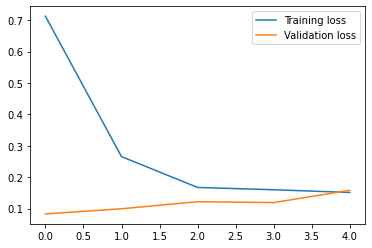

In [15]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()